In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pandas as pd
import glob
import shutil

import sys
sys.path.append("your path\\Anaconda3\\models\\research\\")
sys.path.append("your path\\Anaconda3\\models\\research\\object_detection\\utils")


In [2]:
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


## Env setup

In [3]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [4]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

C:\Users\Vibha2023\Anaconda3\models\research\object_detection\utils\visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\Vibha2023\Anaconda3\envs\tfp3.6\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Vibha2023\Anaconda3\envs\tfp3.6\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Vibha2023\Anaconda3\envs\tfp3.6\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Vibha2023\Anaconda3\envs\tfp3.6\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Vibha2023\Anaconda3\envs\tfp3.6\lib\

# Model preparation 

In [5]:
# Model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
#MODEL_NAME = 'rfcn_resnet101_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [7]:
#This is required to be run the first time the model is downloaded. 
#For subsequent executions, only loading the frozen model would suffice.
'''
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())
'''

"\nopener = urllib.request.URLopener()\nopener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)\ntar_file = tarfile.open(MODEL_FILE)\nfor file in tar_file.getmembers():\n  file_name = os.path.basename(file.name)\n  if 'frozen_inference_graph.pb' in file_name:\n    tar_file.extract(file, os.getcwd())\n"

## Load a (frozen) Tensorflow model into memory.

In [8]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `0`, we know that this corresponds to `bed`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [9]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [10]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size

  
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [11]:
import os
print(os.path)

<module 'ntpath' from 'C:\\Users\\Vibha2023\\Anaconda3\\envs\\tfp3.6\\lib\\ntpath.py'>


In [ ]:

# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
import urllib
url = 'https://9994297241.000webhostapp.com/uploads/5b73f91e3e7e6_bed2.jpg'

urllib.request.urlretrieve(url,"test_images//bed2.jpg")


In [12]:

PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = os.path.join(PATH_TO_TEST_IMAGES_DIR)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [13]:
TEST_IMAGE_PATHS

'test_images'

In [14]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.4), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [15]:
from scipy.misc import imread, imsave, imresize
import cv2

test_images\bed1.jpg


C:\Users\Vibha2023\Anaconda3\envs\tfp3.6\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


Number of classes in the image: 2
bad
test_images\bed1_M.jpg
test_images\bed2.jpg
Number of classes in the image: 1
good
test_images\bed2_M.jpg
test_images\bed3.jpg
Number of classes in the image: 0
bad
test_images\bed3_M.jpg
test_images\chair1.jpg
Number of classes in the image: 2
bad
test_images\chair1_M.jpg
test_images\chair2.jpg
Number of classes in the image: 2
bad
test_images\chair2_M.jpg
test_images\chair3.jpg
Number of classes in the image: 0
bad
test_images\chair3_M.jpg
test_images\chair4.jpg
Number of classes in the image: 1
good
test_images\chair4_M.jpg
test_images\chair5.jpg
Number of classes in the image: 0
bad
test_images\chair5_M.jpg
test_images\chair6.jpg
Number of classes in the image: 1
good
test_images\chair6_M.jpg
test_images\cupboard1.jpg
Number of classes in the image: 1
good
test_images\cupboard1_M.jpg
test_images\cupboard2.jpg
Number of classes in the image: 0
bad
test_images\cupboard2_M.jpg
test_images\cupboard3.jpg
Number of classes in the image: 0
bad
test_im

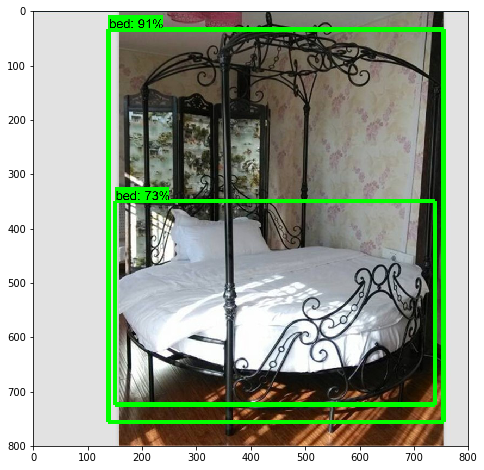

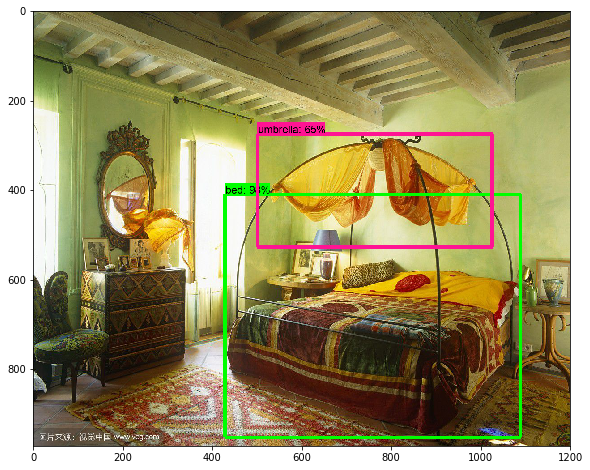

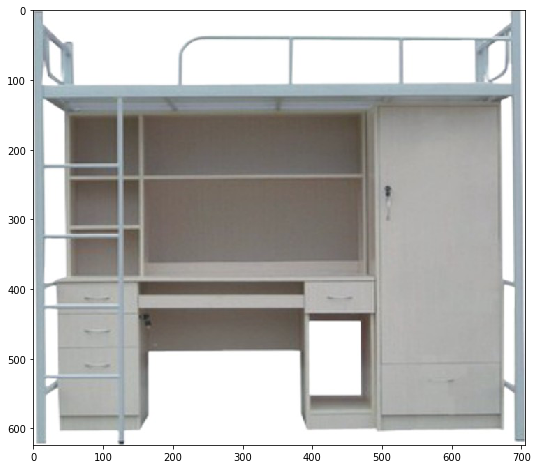

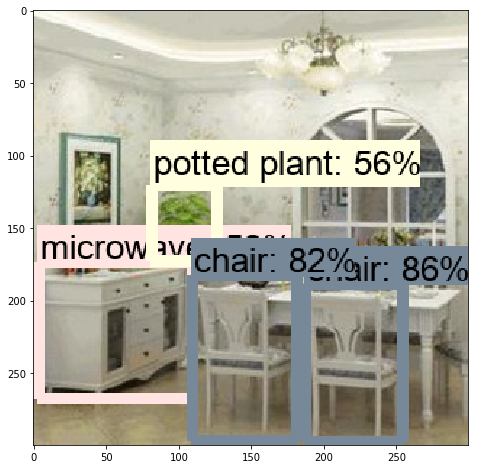

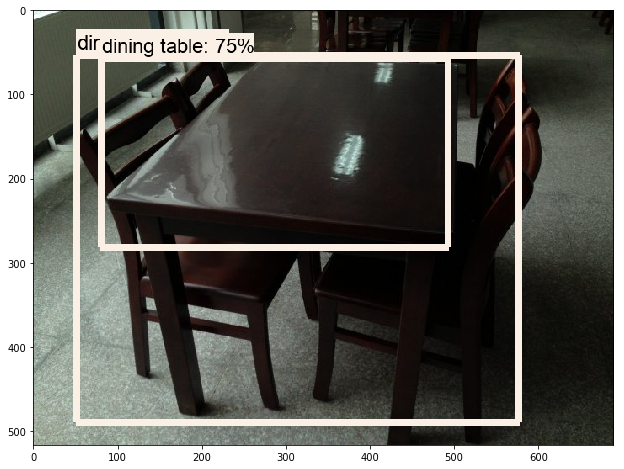

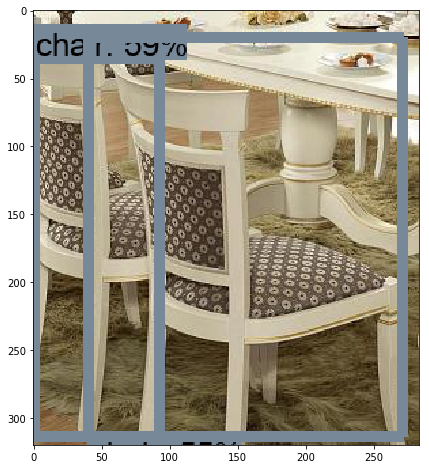

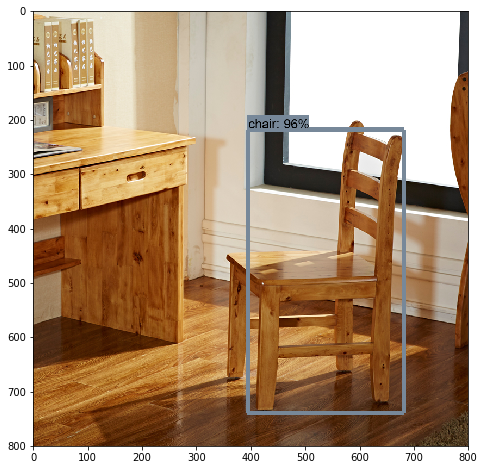

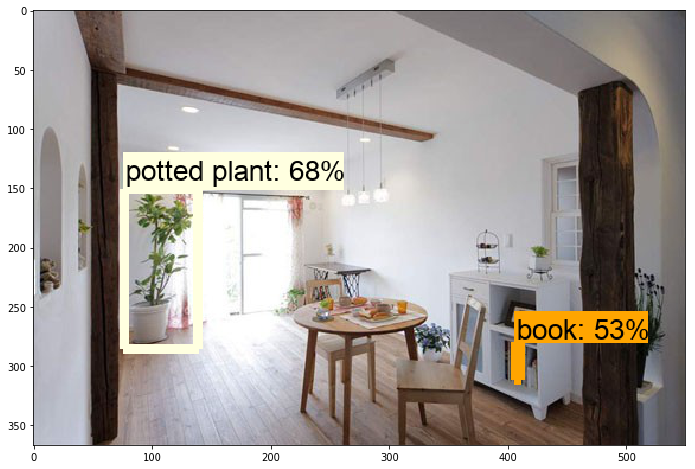

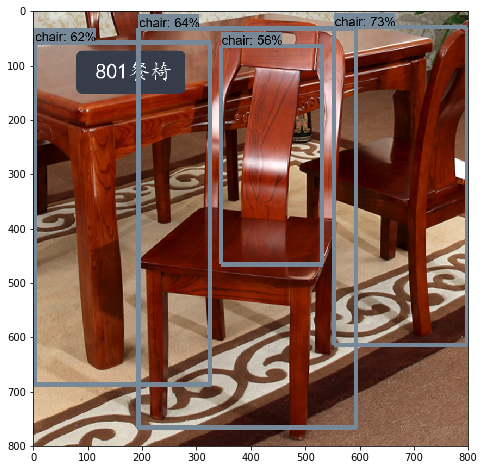

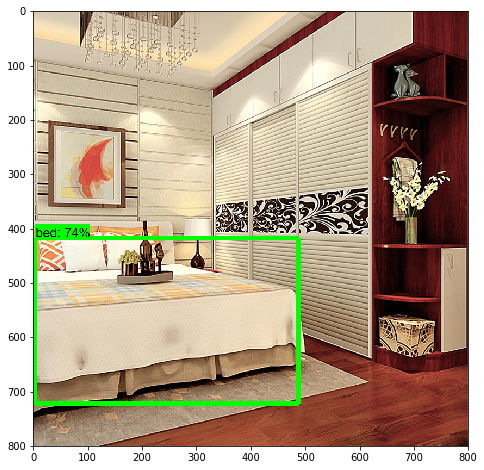

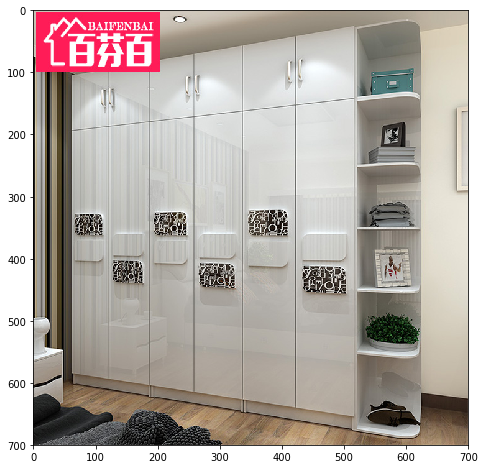

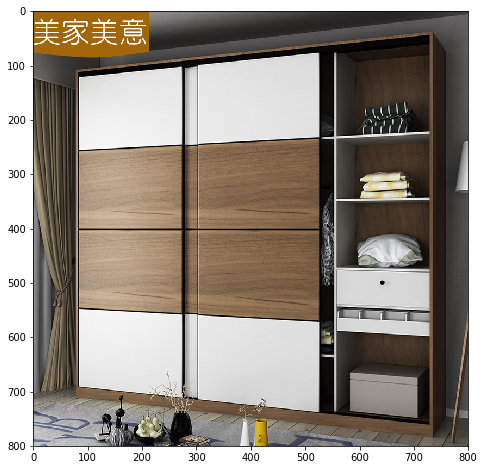

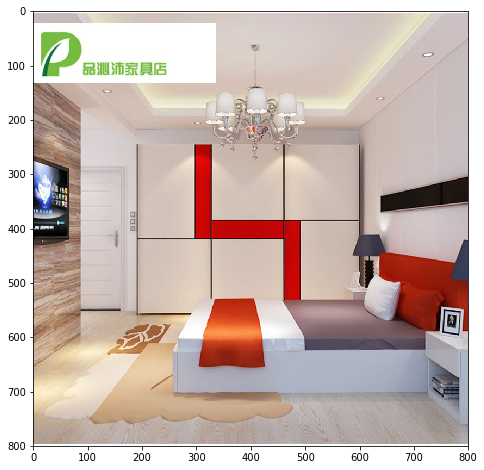

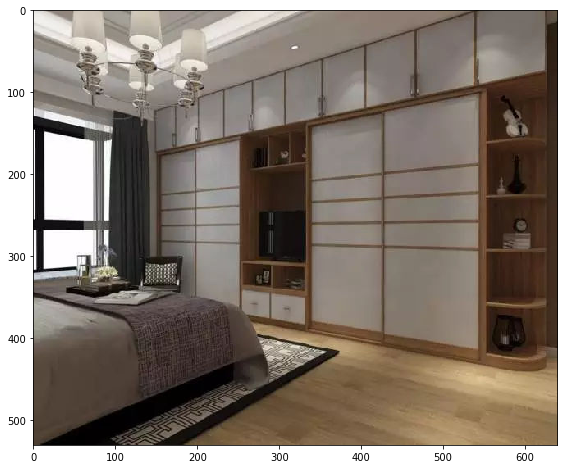

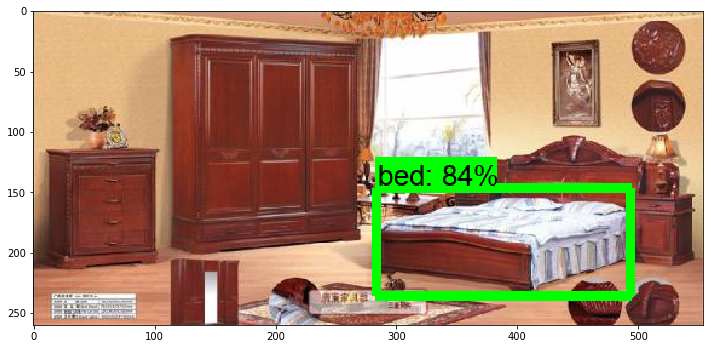

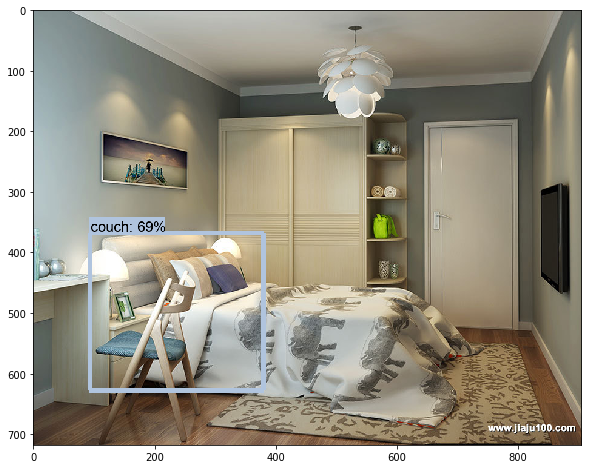

In [20]:
for image_path in glob.glob(TEST_IMAGE_PATHS + "/*.jpg"):
    print(image_path)
#for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_scale = imread(image_path)
    if(len(image_scale.shape)<3):
        names = image_path.split('\\')
        filename = names[1]
               
        new_path ="test_images/output/bad/" + str(filename)
        
        shutil.copyfile(image_path, new_path)
        pass
    elif len(image_scale.shape)==3:
        image_np = load_image_into_numpy_array(image)

 
 
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
        output_dict = run_inference_for_single_image(image_np, detection_graph)
    
   # store boxes in dataframe!
        cut_off_scores = len(list(filter(lambda x: x >= 0.1, output_dict['detection_scores'])))
        detect_scores = []
        detect_classes = []
        detect_ymin = []
        detect_xmin = []
        detect_ymax = []
        detect_xmax = []
        for j in range(cut_off_scores):
            detect_scores.append(output_dict['detection_scores'][j])
            detect_classes.append(output_dict['detection_classes'][j])
       # Assumption: ymin, xmin, ymax, xmax:
            boxes = output_dict['detection_boxes'][j]
            detect_ymin.append(boxes[0])
            detect_xmin.append(boxes[1])
            detect_ymax.append(boxes[2])
            detect_xmax.append(boxes[3])
      
            Identifier = image_path
            Id_list = image_path
            Detected_objects = pd.DataFrame({'Image': Id_list,'Score': detect_scores,'Class': detect_classes})
        
        num_classes = len(Detected_objects[Detected_objects['Score']>0.7])
        print("Number of classes in the image: " + str(num_classes))
    
        image_type=""
    
        names = Id_list.split('\\')
        filename = names[1]

        if num_classes==1:
            image_type = "good"
            new_path ="test_images/output/good/" + str(filename)
            #print("New Path: " + new_path)
            shutil.copyfile(Id_list, new_path)
        else:
            image_type = "bad"
            new_path ="test_images/output/bad/" + str(filename)
            #print("New Path: " + new_path)
            shutil.copyfile(Id_list, new_path)

        print(image_type)
    
                # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks'),
            use_normalized_coordinates=True,
            line_thickness=8)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)
    